In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/shwetank/code/makemore-utils-nbs')
from utils import create_dataset, CharDataset, evaluate_loss, print_samples, get_lr_loss
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import random
from sklearn.manifold import TSNE
import numpy as np
import torch

In [2]:
## Device toggle
device = torch.device("mps")
# device = torch.device("cpu")

In [3]:
# Read file and create training and test sets
names, vocab, max_length = create_dataset('../names.txt')
vocab_size = len(vocab) + 1 # Blank token
block_length = max_length + 1
# print(len(names), vocab, max_length)
seed_value = 42
random.seed(seed_value)
n1 = int(0.9*len(names))
random.shuffle(names)
# print(names[0:5], names_ss[0:5]) # check that dataset is shuffled
train_data = CharDataset(names[:n1], vocab=vocab, max_length=max_length)
test_data = CharDataset(names[n1:], vocab=vocab, max_length=max_length)


In [4]:
# ## Hyperparameters
emb_dim = 64
head_size = 128
dropout = 0.2

In [9]:
class Xformer(nn.Module):
    def __init__(self, emb_dim, num_heads):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size + 1, emb_dim)
        self.pos_embedding = nn.Embedding(vocab_size + 1, emb_dim)
        self.decoder_layers = nn.TransformerDecoderLayer(d_model=emb_dim, nhead=4)
        self.transformer_decoder = nn.TransformerDecoder(self.decoder_layers, num_layers=3)
        self.layer_norm = nn.LayerNorm(emb_dim)
        self.lm_head = nn.Linear(emb_dim, vocab_size)

    def forward(self, x, targets=None):
        tok_emb = self.token_embedding(x)
        pos_emb = self.pos_embedding(x)
        x = tok_emb + pos_emb  # B, T, emb_dim
        memory = x.clone()  # Initialize memory with the input
        x = self.transformer_decoder(x, memory)
        x = self.layer_norm(x)
        logits = self.lm_head(x)  # B, T, vocab_size

        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            # print(logits.view(-1, logits.size(-1)).shape, targets.view(-1).shape)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        return(logits,loss)

In [10]:
# # Test run on a batch size of 1 for debug
batch_size = 1
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
model = Xformer(emb_dim, head_size).to(device)
optimizer = Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
xb, yb = next(iter(train_dataloader))
xb = xb.to(device)
yb = yb.to(device)
# print(xb.shape, yb.shape)
logits, loss = model(xb,yb)
print(loss)

tensor(3.2877, device='mps:0', grad_fn=<NllLossBackward0>)


In [19]:
# Set up optimizer and model
batch_size = 256
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
model = Xformer(emb_dim, head_size).to(device)
optimizer = Adam(model.parameters(), lr=0.001)

In [20]:
xb, yb = next(iter(train_dataloader))
xb = xb.to(device)
yb = yb.to(device)
logits, loss = model(xb,yb)
print(loss)

tensor(3.4192, device='mps:0', grad_fn=<NllLossBackward0>)


In [21]:
# ## Optimal lr sweep
# import matplotlib.pyplot as plt
# lri, lossi =  get_lr_loss(model, optimizer, train_dataloader, batch_size, 500, -2, -1.5)
# plt.plot(lri, lossi)
# # Add labels to the x-axis and y-axis
# plt.xlabel('LR (Learning Rate)')
# plt.ylabel('Loss')

In [22]:
# Training loop - Initialized in separate loop so that it can be re run without reinitialization that will wipe things out
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

tr_loss = []
te_loss = []

In [25]:
# Training loop 
lr = 0.001
optimizer = Adam(model.parameters(), lr=lr)
n_epochs = 1000
for steps in range(n_epochs):
    xb, yb = next(iter(train_dataloader))
    xb = xb.to(device)
    yb = yb.to(device)
    logits, loss = model(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    tr_lossi, te_lossi = evaluate_loss(model, train_dataloader, test_dataloader, device, num_batches=10)
    tr_loss.append(tr_lossi)
    te_loss.append(te_lossi)
    # print(loss.item())

    # if steps % 99 == 0:
    #     print('ltr: ', ltr, 'lte: ', lte, 'single shot loss:', loss.item())

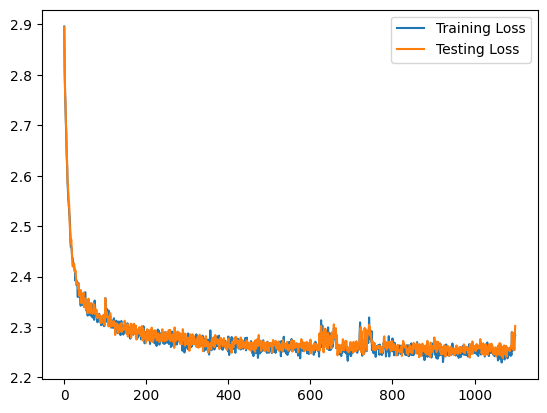

training loss:  2.2531
validation loss:  2.2576


In [26]:
## Plot loss 
import matplotlib.pyplot as plt

plt.plot(tr_loss, label='Training Loss')
plt.plot(te_loss, label='Testing Loss')
plt.legend()
plt.show()
print('training loss: ', round(torch.mean(torch.tensor(tr_loss[-100:])).item(),4)), 
print('validation loss: ', round((torch.mean(torch.tensor(te_loss[-100:]))).item(),4))

In [27]:
## Pretty print the samples
print_samples(model, train_data, max_length, device, num=32)

kenen
brrnto
noili
yorinonana
rylen
advryan
kiyleya
zalae
raltya
cadl
zeirienarorah
cazllie
akyer
lenkayam
rodiassson
moman
kynnan
dobe
mila
briellyar
areyaa
orvan
tresia
cachellerie
jaseliya
yenenananah
whrayr
koe
ashmon
xilauadime
arilah
reiydy


['stop', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'blank']


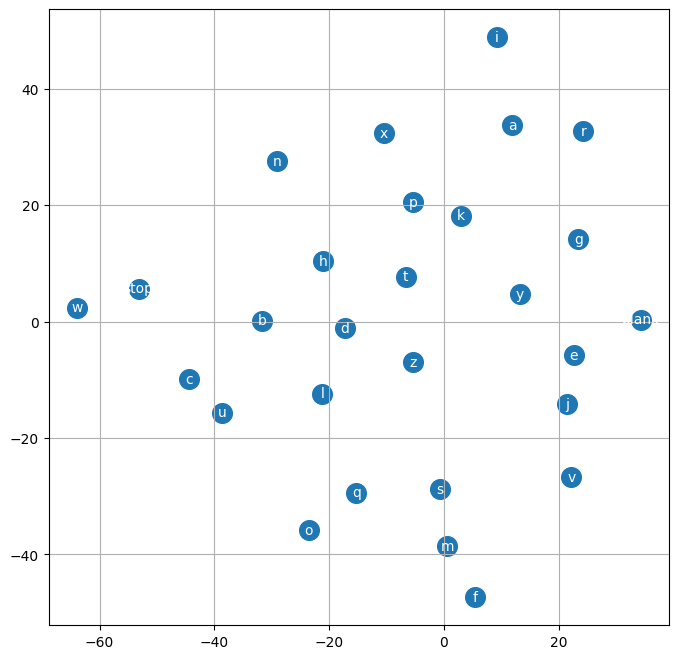

In [28]:
## Plot tsne or pca for embeddings
# t-SNE example:
embeddings_matrix = model.token_embedding.weight.data.cpu().numpy()
tsne = TSNE(n_components=2, perplexity=7)
reduced_embeddings = tsne.fit_transform(embeddings_matrix)

# Create vectors for ticklabels
ticklabels = list(train_data.itos.values())
ticklabels.insert(0,'stop')
ticklabels.insert(27,'blank')
x_ticklabel_vec = np.arange(len(ticklabels))
y_ticklabel_vec = np.arange(len(ticklabels))
print(ticklabels)

# visualize dimensions 0 and 1 of the embedding matrix for all characters
plt.figure(figsize=(8,8))
plt.scatter(reduced_embeddings[:,0].data, reduced_embeddings[:,1].data, s=200)
for i in range(embeddings_matrix.shape[0]):
    plt.text(reduced_embeddings[i,0].item(), reduced_embeddings[i,1].item(), ticklabels[i], ha="center", va="center", color='white')
plt.grid('minor')